In [1]:
## Initial setup
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

import os
from dotenv import load_dotenv

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)
backend = service.backend(name="ibm_rensselaer")

### Create the Uf subcircuits for f from parts (a), (b), and (c)
$$f(x) = \frac{1}{2} \left(1 + (-1)^{a^\intercal x (\text{mod k})}\right)$$

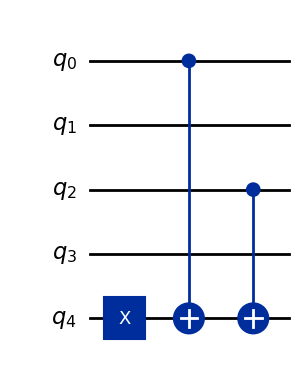

In [2]:
# The first and third elements of a are odd, and k = 2
Uf_a = qiskit.QuantumCircuit(5)
Uf_a.x(4)
Uf_a.cx(0, 4)
Uf_a.cx(2, 4)
Uf_a_gate = Uf_a.to_gate()
Uf_a.draw(output='mpl')

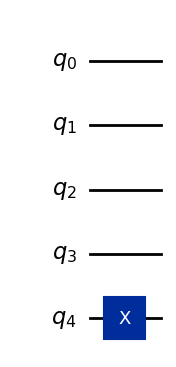

In [3]:
# a is entirely even, and k = 2
Uf_b = qiskit.QuantumCircuit(5)
Uf_b.x(4)
Uf_b_gate = Uf_b.to_gate()
Uf_b.draw(output='mpl')

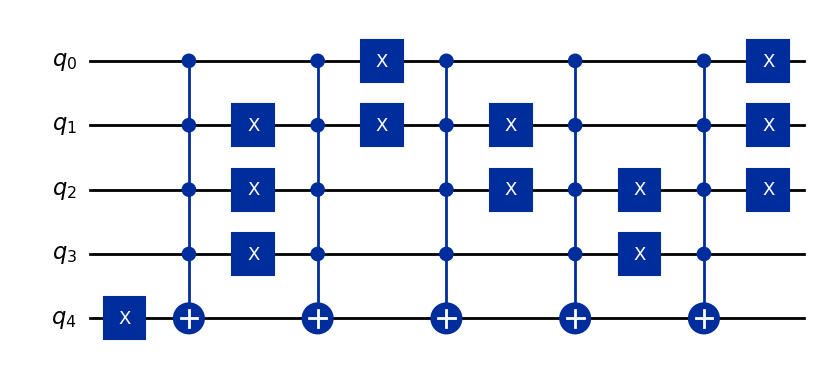

In [4]:
# a = [1, 1, 1, 1] and k = 3
# z gets flipped unless exactly 1 or 4 of the first 4 qubits are 1
Uf_c = qiskit.QuantumCircuit(5)
Uf_c.x(4)

# if all 4 qubits are 1, z is flipped
Uf_c.mcx([0, 1, 2, 3], 4)

Uf_c.x(1)
Uf_c.x(2)
Uf_c.x(3)

# if 0th is 1 and the rest are 0, z is flipped
Uf_c.mcx([0, 1, 2, 3], 4)

Uf_c.x(0)
Uf_c.x(1)

# if 1st is 1 and the rest are 0, z is flipped
Uf_c.mcx([0, 1, 2, 3], 4)

Uf_c.x(1)
Uf_c.x(2)

# if 2nd is 1 and the rest are 0, z is flipped
Uf_c.mcx([0, 1, 2, 3], 4)

Uf_c.x(2)
Uf_c.x(3)

# if 3rd is 1 and the rest are 0, z is flipped
Uf_c.mcx([0, 1, 2, 3], 4)

Uf_c.x(0)
Uf_c.x(1)
Uf_c.x(2)

Uf_c_gate = Uf_c.to_gate()
Uf_c.draw(output='mpl')

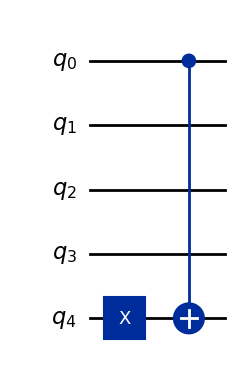

In [10]:
# The first element of a is odd, and k = 2
Uf_d = qiskit.QuantumCircuit(5)
Uf_d.x(4)
Uf_d.cx(0, 4)
Uf_d_gate = Uf_d.to_gate()
Uf_d.draw(output='mpl')

In [6]:
def check_balance_circuit(Uf):
    # 5 qubits and 4 classical bits to measure the first 4 qubits at the end
    qc = qiskit.QuantumCircuit(5, 4)
    qc.initialize("00000")
    # initial state (entagle)
    qc.h([0, 1, 2, 3])
    qc.x(4)
    qc.h(4)
    # run the Uf
    qc.append(Uf, [0, 1, 2, 3, 4])
    # detangle and measure
    qc.h([0, 1, 2, 3])
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    return qc

def check_balance_results(Uf):
    qc = check_balance_circuit(Uf)
    qc = qiskit.transpile(qc, backend)
    job = backend.run(qc, shots=10**4)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [7]:
counts_a = check_balance_results(Uf_a_gate)

/tmp/ipykernel_4452/1197298169.py:19: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc, shots=10**4)


In [8]:
counts_b = check_balance_results(Uf_b_gate)

/tmp/ipykernel_4452/1197298169.py:19: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc, shots=10**4)


In [9]:
counts_c = check_balance_results(Uf_c_gate)

/tmp/ipykernel_4452/1197298169.py:19: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc, shots=10**4)


In [7]:
counts_d = check_balance_results(Uf_d_gate)

/tmp/ipykernel_44438/1197298169.py:19: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc, shots=10**4)


In [8]:
def _print_latex_probabilities_table(counts, shots=10**4):
    # print start of table
    print("""\\begin{center}
    \\begin{tabular}{|c|c|}
        \\hline
        $x_1$ $x_2$ $x_3$ $x_4$ & $P(x)$ \\\\
        \\hline""")
    for i in range(16):
        binary = format(i, '04b')
        little_endian = binary[::-1]
        frequency = counts.get(little_endian, 0)
        print(f"        {binary} & {frequency/shots} \\\\")

    # print end of table
    print("""        \\hline
    \\end{tabular}
\\end{center}""")

def print_probabilities_table(counts, shots=10**4, latex=False):
    if latex:
        return _print_latex_probabilities_table(counts, shots)
    
    print("x1 x2 x3 x4 | probability")
    for i in range(16):
        binary = format(i, '04b')
        little_endian = binary[::-1]
        frequency = counts.get(little_endian, 0)
        print(binary, "      |", frequency/shots)


In [16]:
print_probabilities_table(counts_a, latex=True)

\begin{center}
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ $x_4$ & $P(x)$ \\
        \hline
        0000 & 0.0032 \\
        0001 & 0.0 \\
        0010 & 0.0207 \\
        0011 & 0.0 \\
        0100 & 0.0 \\
        0101 & 0.0 \\
        0110 & 0.0 \\
        0111 & 0.0 \\
        1000 & 0.0069 \\
        1001 & 0.0 \\
        1010 & 0.9678 \\
        1011 & 0.0009 \\
        1100 & 0.0 \\
        1101 & 0.0 \\
        1110 & 0.0005 \\
        1111 & 0.0 \\
        \hline
    \end{tabular}
\end{center}


In [17]:
print_probabilities_table(counts_b, latex=True)

\begin{center}
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ $x_4$ & $P(x)$ \\
        \hline
        0000 & 0.9908 \\
        0001 & 0.0012 \\
        0010 & 0.0003 \\
        0011 & 0.0 \\
        0100 & 0.0073 \\
        0101 & 0.0 \\
        0110 & 0.0 \\
        0111 & 0.0 \\
        1000 & 0.0004 \\
        1001 & 0.0 \\
        1010 & 0.0 \\
        1011 & 0.0 \\
        1100 & 0.0 \\
        1101 & 0.0 \\
        1110 & 0.0 \\
        1111 & 0.0 \\
        \hline
    \end{tabular}
\end{center}


In [18]:
print_probabilities_table(counts_c, latex=True)

\begin{center}
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ $x_4$ & $P(x)$ \\
        \hline
        0000 & 0.0679 \\
        0001 & 0.0731 \\
        0010 & 0.0576 \\
        0011 & 0.0557 \\
        0100 & 0.0642 \\
        0101 & 0.0736 \\
        0110 & 0.0545 \\
        0111 & 0.0635 \\
        1000 & 0.0639 \\
        1001 & 0.066 \\
        1010 & 0.0575 \\
        1011 & 0.0602 \\
        1100 & 0.0648 \\
        1101 & 0.0615 \\
        1110 & 0.0546 \\
        1111 & 0.0614 \\
        \hline
    \end{tabular}
\end{center}


In [9]:
print_probabilities_table(counts_d, latex=True)

\begin{center}
    \begin{tabular}{|c|c|}
        \hline
        $x_1$ $x_2$ $x_3$ $x_4$ & $P(x)$ \\
        \hline
        0000 & 0.0051 \\
        0001 & 0.0 \\
        0010 & 0.0 \\
        0011 & 0.0 \\
        0100 & 0.0 \\
        0101 & 0.0 \\
        0110 & 0.0 \\
        0111 & 0.0 \\
        1000 & 0.9918 \\
        1001 & 0.0017 \\
        1010 & 0.0008 \\
        1011 & 0.0 \\
        1100 & 0.0006 \\
        1101 & 0.0 \\
        1110 & 0.0 \\
        1111 & 0.0 \\
        \hline
    \end{tabular}
\end{center}
